# The TESS full-frame images lightcurve of nova V606 Vul extracted using LightKurve package

This notebook is created to address the referee's comments on the paper "TESS photometry of the nova eruption in V606 Vul: asymmetric photosphere and multiple ejections?" ([arXiv e-print](https://arxiv.org/abs/2311.04903)) submitted to ApJ. While we direct readers to the paper for the final period analysis, this notebook reproduces the main claim: the presence of a ~0.1277 day period in the nova light curve near its peak brightness, using only the standard TESS data analysis package [LightKurve](https://github.com/lightkurve/lightkurve).

The eruption of V606 Vul was happening during the TESS Sector 41 and we start with the analysis of the eruption lightcurve. The same analysis is then applied to the two pre-eruption and three post-eruption TESS sectors covering the nova position to reveal that these sectors contain no useful data as the nova is too faint for TESS outside Sector 41.

In [1]:
# Import the packages needed for the analysis
import os
import lightkurve as lk
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def simple_detrend_and_period_search(lc, period_range=(0.05, 2)):
    """
    Process a LightCurve: clip outliers, detrend, and perform Lomb-Scargle period search.

    Parameters:
    lc (LightCurve): The LightCurve object to process.
    period_range (tuple): The range of periods (in days) to search for periods, default is (0.05, 2).

    Returns:
    float: The best period detected by the Lomb-Scargle periodogram.
    """
    # Step 1: Clip the lightcurve at 3-sigma
    clipped_lc = lc.remove_outliers(sigma=3)
    clipped_lc.plot(title="Clipped lightcurve (3-sigma)")
    plt.show()

    # Step 2: Detrend the lightcurve using a 3rd-degree polynomial
    detrended_lc = clipped_lc.flatten(window_length=101, polyorder=5)
    detrended_lc.plot(title="Detrended lightcurve")
    plt.show()
    
    # Step 2.5: Clip the lightcurve again to remove mini-flares
    detrended_lc = detrended_lc.remove_outliers(sigma=3)
    detrended_lc.plot(title="Clipped lightcurve (3-sigma) after detrending")
    plt.show()    

    # Step 3: Perform Lomb-Scargle periodogram analysis using LightKurve's built-in functionality
    min_period, max_period = period_range
    min_frequency = 1 / max_period
    max_frequency = 1 / min_period

    # Create the periodogram
    periodogram = detrended_lc.to_periodogram(method="lombscargle", 
                                              minimum_frequency=min_frequency, 
                                              maximum_frequency=max_frequency)

    # Find and print the best period
    best_period = periodogram.period_at_max_power
    print(f"The best period is: {best_period:.4f} days")

    # Step 4: Plot the periodogram as a function of frequency
    plt.figure(figsize=(10, 5))
    plt.plot(periodogram.frequency.value, periodogram.power, label="Lomb-Scargle Power")
    plt.axvline(x=1/best_period.value, color="red", linestyle="--", label=f"Best Period = {best_period:.4f} days")
    plt.xlabel("Frequency (1/day)")
    plt.ylabel("Power")
    plt.title("Lomb-Scargle Periodogram (Frequency Domain)")
    plt.legend()
    plt.grid()
    plt.show()

    return best_period.value


In [3]:
def extract_tess_lightcurve(tpf_cutout, target_source_name, notebook_name="v606_vul_lk_square_aperture"):
    """
    Process TESS lightcurve data from a TPF cutout and save various plots and CSV files in a dedicated directory.

    Parameters:
    tpf_cutout: TargetPixelFile
        The TPF cutout object containing the data.
    target_source_name: str
        The name of the target source.
    notebook_name: str
        The name of the Jupyter notebook (used to name the output directory).
    """
    # Create output directory
    output_dir = notebook_name.lower().replace(" ", "_")
    os.makedirs(output_dir, exist_ok=True)

    # Define and plot the source aperture mask
    custom_mask = np.zeros((tpf_cutout[0].shape[1:]), dtype='bool')
    custom_mask[5:8, 5:8] = True  # custom mask coordinates

    # Define file names
    target_source_name_lowercase_for_filename = target_source_name.lower().replace(" ", "_")
    sector_name_lowercase_for_filename = f"sector{tpf_cutout.sector}"

    # Plot the source aperture
    tpf_cutout.plot(aperture_mask=custom_mask)
    plt.title(f"{target_source_name}, TESS Sector {tpf_cutout.sector}, source aperture")
    plt.savefig(os.path.join(output_dir, f"{target_source_name_lowercase_for_filename}_{sector_name_lowercase_for_filename}_lk_src_aperture_plot.png"), format="png", dpi=300)
    plt.savefig(os.path.join(output_dir, f"{target_source_name_lowercase_for_filename}_{sector_name_lowercase_for_filename}_lk_src_aperture_plot.eps"), format="eps")
    plt.close()

    # Extract and save the raw source lightcurve
    uncorrected_lc = tpf_cutout.to_lightcurve(aperture_mask=custom_mask)
    uncorrected_lc.plot(lw=2, marker='.', linestyle='None')
    plt.title(f"{target_source_name}, TESS Sector {tpf_cutout.sector}, raw lightcurve")
    plt.savefig(os.path.join(output_dir, f"{target_source_name_lowercase_for_filename}_{sector_name_lowercase_for_filename}_lk_raw_plot.png"), format="png", dpi=300)
    uncorrected_lc.to_csv(os.path.join(output_dir, f"{target_source_name_lowercase_for_filename}_{sector_name_lowercase_for_filename}_lk_raw.csv"), overwrite=True)
    plt.close()

    # Create and display the background aperture
    background_mask = ~tpf_cutout.create_threshold_mask(threshold=0.001, reference_pixel=None) * ~custom_mask
    tpf_cutout.plot(aperture_mask=background_mask, mask_color='w')
    plt.title(f"{target_source_name}, TESS Sector {tpf_cutout.sector}, background aperture")
    plt.savefig(os.path.join(output_dir, f"{target_source_name_lowercase_for_filename}_{sector_name_lowercase_for_filename}_lk_bck_aperture_plot.png"), format="png", dpi=300)
    plt.savefig(os.path.join(output_dir, f"{target_source_name_lowercase_for_filename}_{sector_name_lowercase_for_filename}_lk_bck_aperture_plot.eps"), format="eps")
    plt.close()

    # Extract background lightcurve
    n_target_pixels = custom_mask.sum()
    n_background_pixels = background_mask.sum()
    background_lc_per_pixel = tpf_cutout.to_lightcurve(aperture_mask=background_mask) / n_background_pixels
    background_estimate_lc = background_lc_per_pixel * n_target_pixels

    # Compute the background-subtracted lightcurve
    bkg_subtracted_lc = uncorrected_lc - background_estimate_lc.flux
    bkg_subtracted_lc.plot(lw=2, marker='.', linestyle='None')
    plt.title(f"{target_source_name}, TESS Sector {tpf_cutout.sector}, background-subtracted lightcurve")
    plt.savefig(os.path.join(output_dir, f"{target_source_name_lowercase_for_filename}_{sector_name_lowercase_for_filename}_lk_bcksub_plot.png"), format="png", dpi=300)
    bkg_subtracted_lc.to_csv(os.path.join(output_dir, f"{target_source_name_lowercase_for_filename}_{sector_name_lowercase_for_filename}_lk_bcksub.csv"), overwrite=True)
    plt.close()

    # Plot and save the background lightcurve
    background_estimate_lc.plot(lw=2, marker='.', linestyle='None')
    plt.title(f"{target_source_name}, TESS Sector {tpf_cutout.sector}, background lightcurve")
    plt.savefig(os.path.join(output_dir, f"{target_source_name_lowercase_for_filename}_{sector_name_lowercase_for_filename}_lk_bck_plot.png"), format="png", dpi=300)
    background_estimate_lc.to_csv(os.path.join(output_dir, f"{target_source_name_lowercase_for_filename}_{sector_name_lowercase_for_filename}_lk_bck.csv"), overwrite=True)
    plt.close()

    # Plot raw, background-subtracted, and background-only lightcurves together
    ax = uncorrected_lc.plot(label="Raw", lw=2, marker='.', linestyle='None')
    bkg_subtracted_lc.plot(ax=ax, label="Background-subtracted", lw=2, marker='.', linestyle='None')
    background_estimate_lc.plot(ax=ax, label="Background", lw=2, marker='.', linestyle='None')
    plt.title(f"{target_source_name}, TESS Sector {tpf_cutout.sector}")
    plt.savefig(os.path.join(output_dir, f"{target_source_name_lowercase_for_filename}_{sector_name_lowercase_for_filename}_lk_raw_backsub_bck_plot.png"), dpi=300)
    plt.savefig(os.path.join(output_dir, f"{target_source_name_lowercase_for_filename}_{sector_name_lowercase_for_filename}_lk_raw_backsub_bck_plot.eps"), format="eps")
    plt.close()

    # Run the simplified period analysis
    print("The simplified period analysis for the background-subtracted source lightcurve")
    simple_detrend_and_period_search(bkg_subtracted_lc, period_range=(0.05, 2.0))
    print("The simplified period analysis for the background lightcurve")
    simple_detrend_and_period_search(background_estimate_lc, period_range=(0.05, 2.0))


# V606 Vul

The target is V606 Vul = Nova Vulpeculae 2021 = TCP J20210770+2914093
The analysis was initially performed with the Nova position measured with the SAI 0.6-m telescope (reported at TOCP http://www.cbat.eps.harvard.edu/unconf/followups/J20210770+2914093.html ):
 20:21:07.703 +29:14:09.25 305.2820958 +29.2359028
The analysis was later re-done using Gaia DR3 position of the likely nova host: 
 20:21:07.7044  +29:14:09.091 305.2821017 +29.2358586
This makes no difference at the TESS image scale of 20"/pix.

In [4]:
# Set target source name and position, search for TESS data
target_source_name="V606 Vul"
# V606 Vul - measured posiiton of the nova (SAI 0.6m telescope)
#search_lc = lk.search_tesscut("20:21:07.703 +29:14:09.25")
# Gaia DR3 position of the counterpart
search_lc = lk.search_tesscut("20:21:07.7044  +29:14:09.091")
search_lc

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 14,2019,TESScut,1426,20:21:07.7044 +29:14:09.091,0.0
1,TESS Sector 15,2019,TESScut,1426,20:21:07.7044 +29:14:09.091,0.0
2,TESS Sector 41,2021,TESScut,475,20:21:07.7044 +29:14:09.091,0.0
3,TESS Sector 55,2022,TESScut,475,20:21:07.7044 +29:14:09.091,0.0
4,TESS Sector 81,2024,TESScut,158,20:21:07.7044 +29:14:09.091,0.0
5,TESS Sector 82,2024,TESScut,158,20:21:07.7044 +29:14:09.091,0.0


## Sector 41 - the eruption

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


The simplified period analysis for the background-subtracted source lightcurve


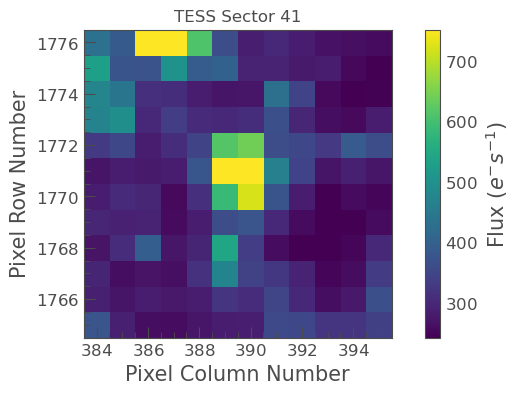

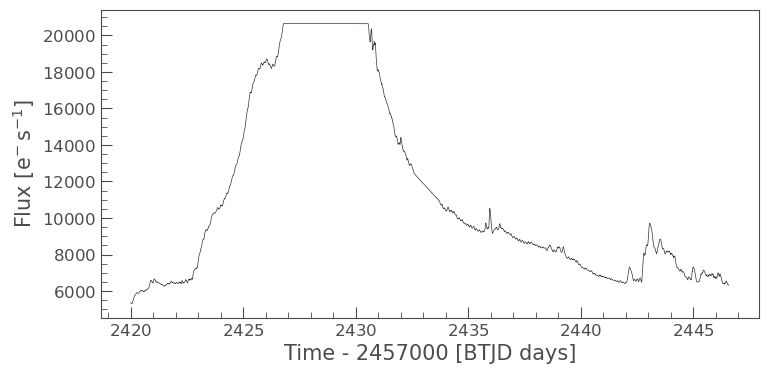

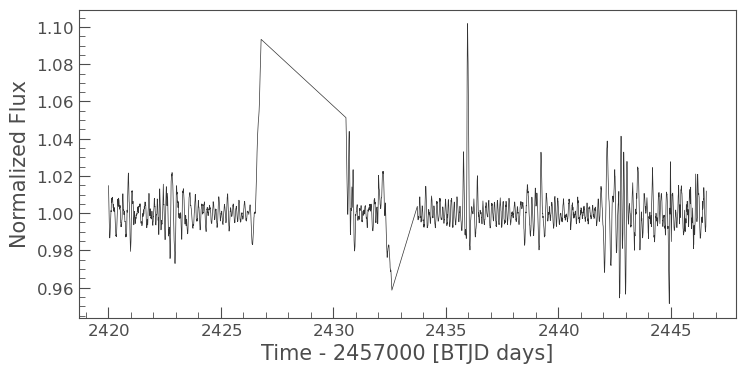

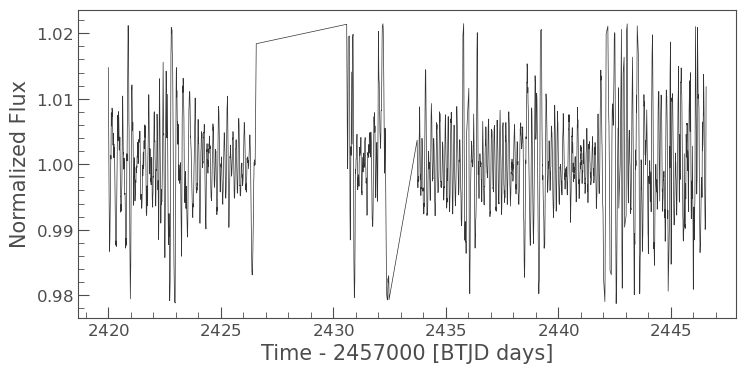

The best period is: 0.1280 d days


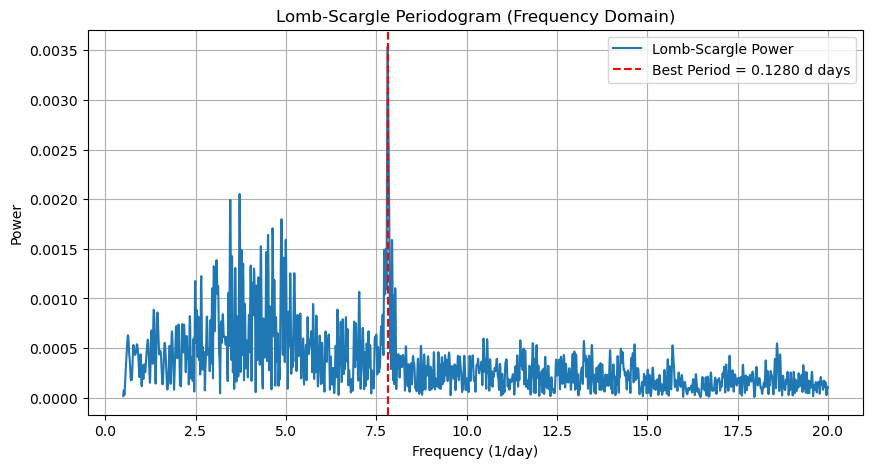

The simplified period analysis for the background lightcurve


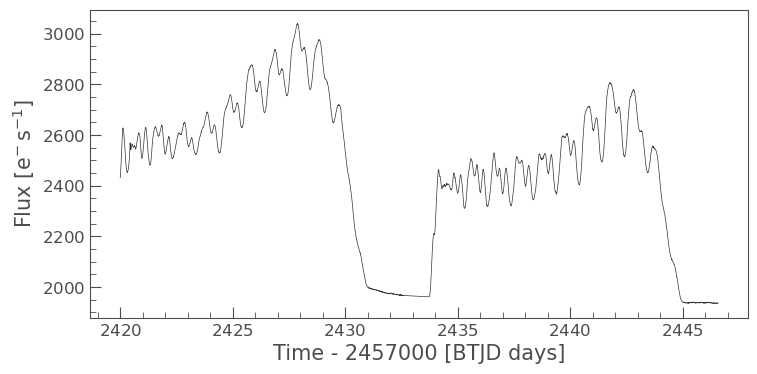

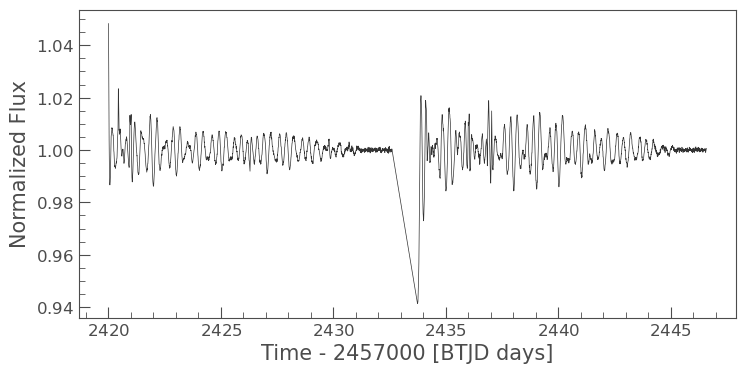

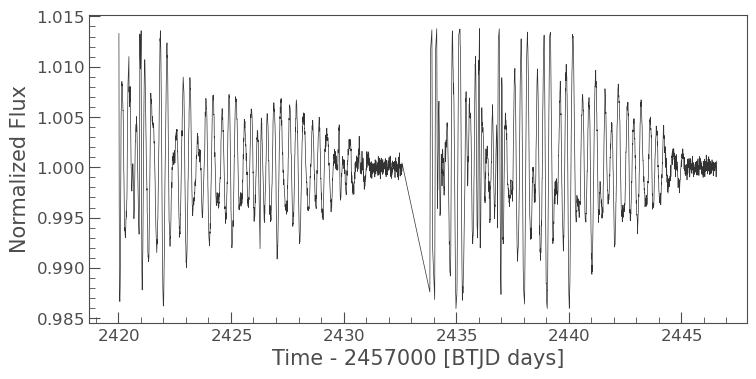

The best period is: 0.3341 d days


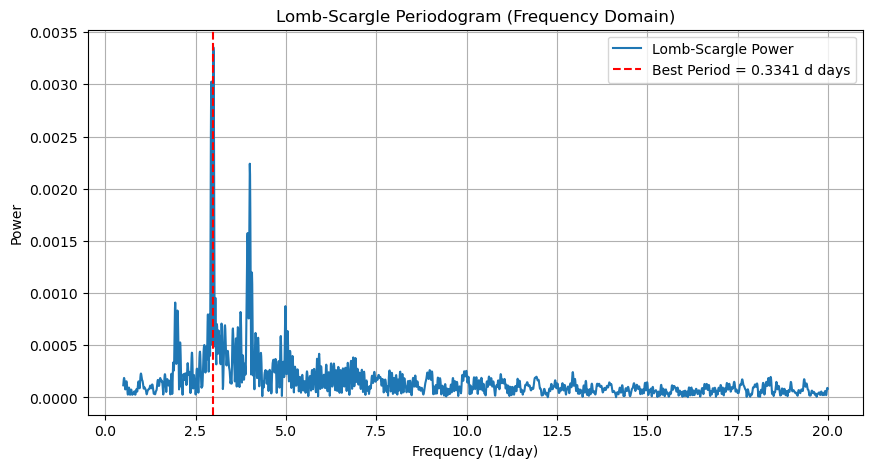

In [5]:
# Download and plot the TESS FFI cutout centered on the source
tpf_cutout = search_lc[2].download(cutout_size=12, quality_bitmask='hard')
tpf_cutout.plot();
# Add the TESS sector name as the title
plt.title(f"TESS Sector {tpf_cutout.sector}")

# Extract the lightcurves and make plots
extract_tess_lightcurve(tpf_cutout, target_source_name)

## Sector 14 - pre-eruption 1

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


The simplified period analysis for the background-subtracted source lightcurve


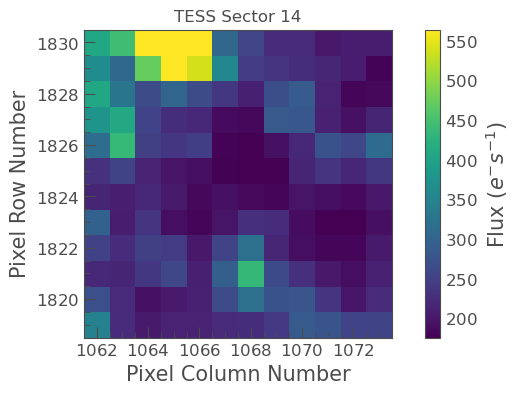

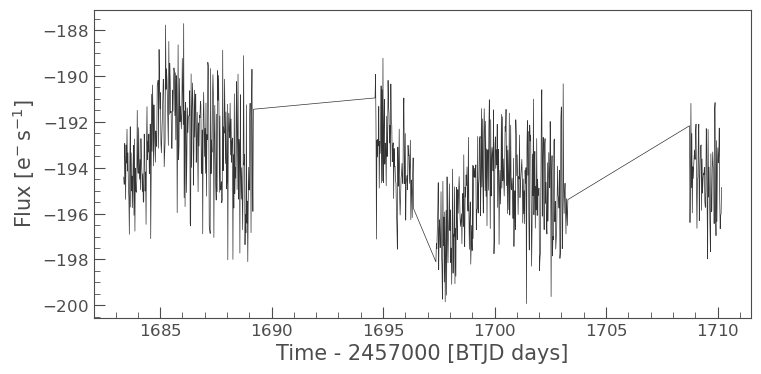

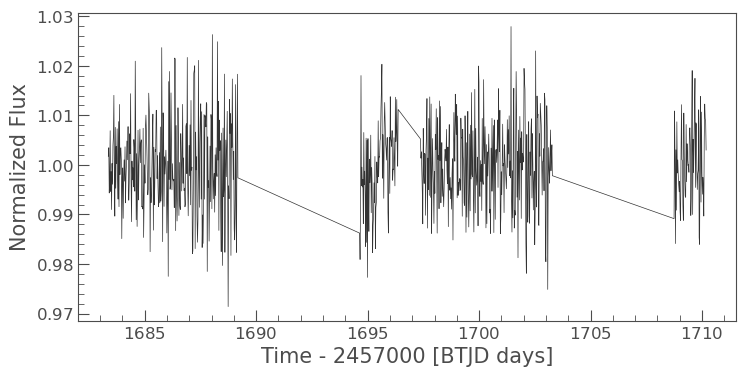

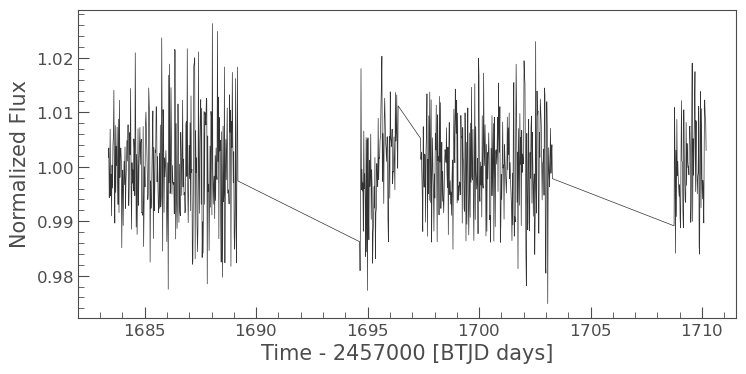

The best period is: 0.0707 d days


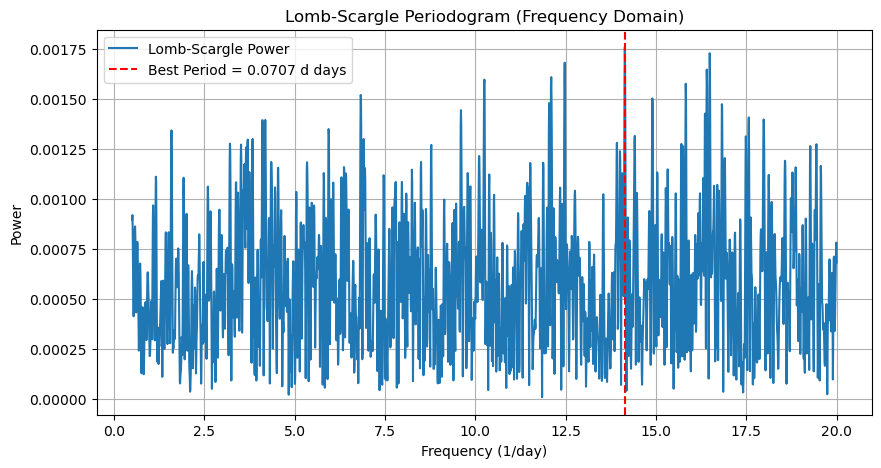

The simplified period analysis for the background lightcurve


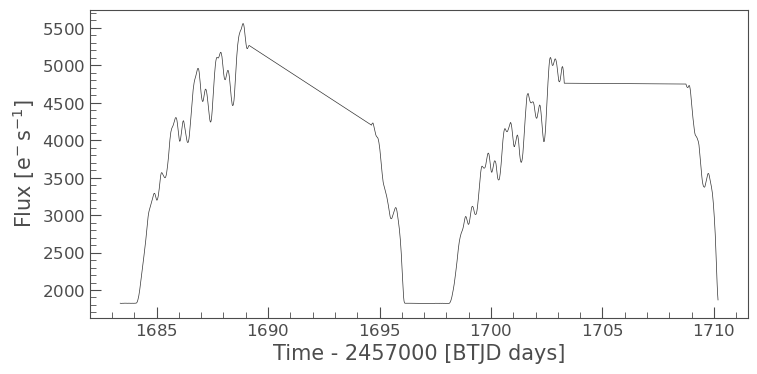

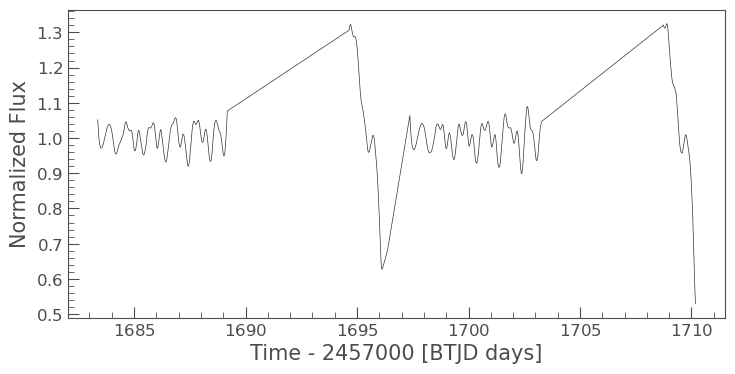

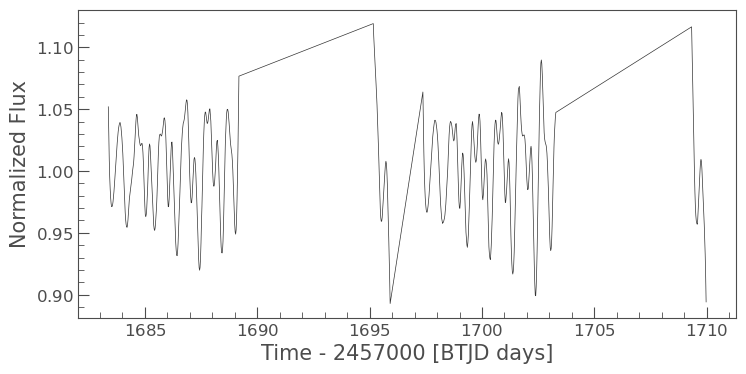

The best period is: 0.9334 d days


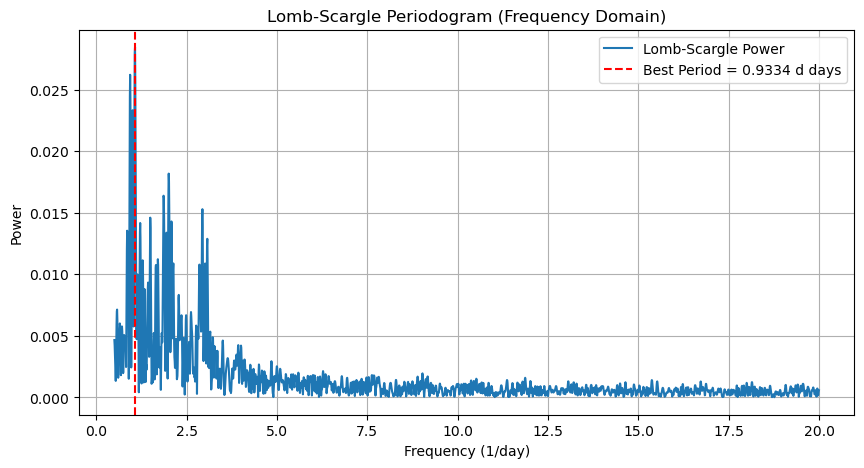

In [6]:
# Download and plot the TESS FFI cutout centered on the source
tpf_cutout = search_lc[0].download(cutout_size=12, quality_bitmask='hard')
tpf_cutout.plot();
# Add the TESS sector name as the title
plt.title(f"TESS Sector {tpf_cutout.sector}")

# Extract the lightcurves and make plots
extract_tess_lightcurve(tpf_cutout, target_source_name)

## Sector 15 - pre-eruption 2

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


The simplified period analysis for the background-subtracted source lightcurve


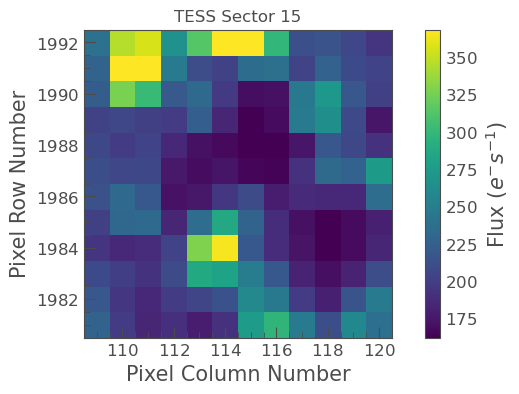

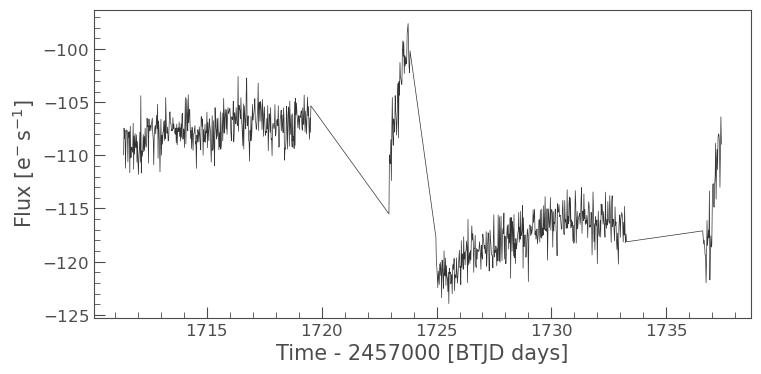

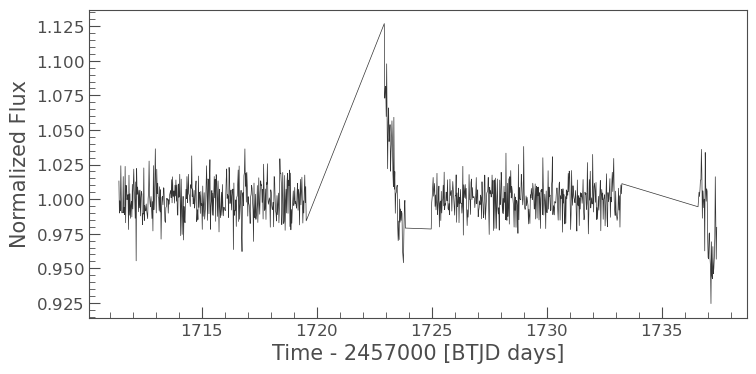

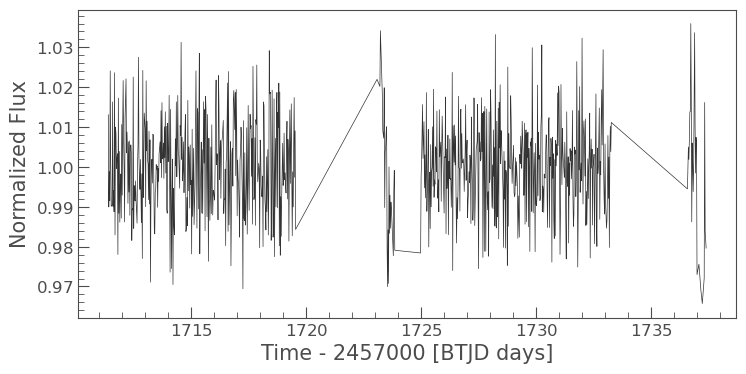

The best period is: 0.7927 d days


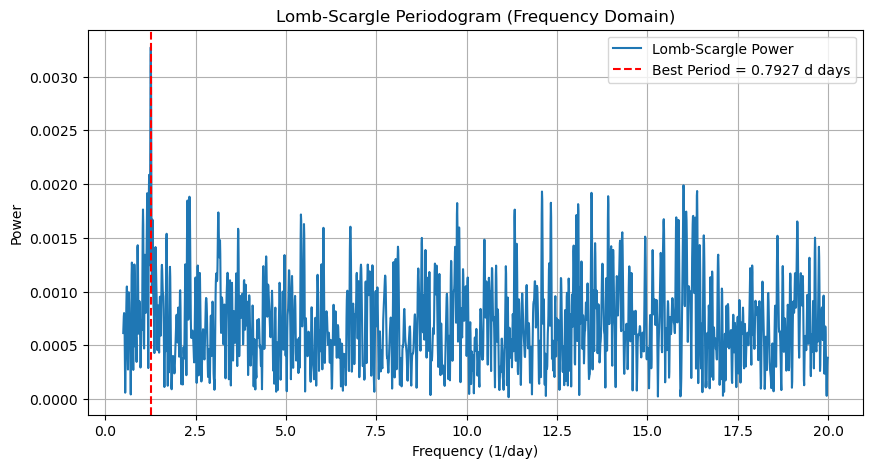

The simplified period analysis for the background lightcurve


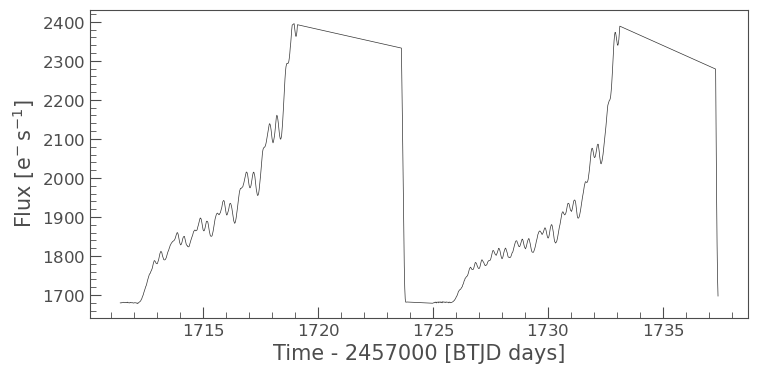

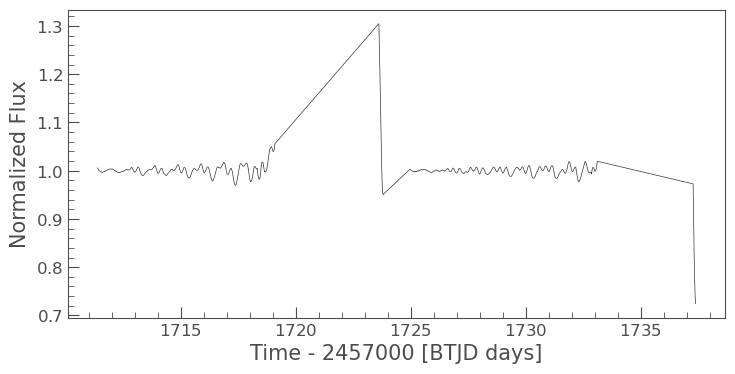

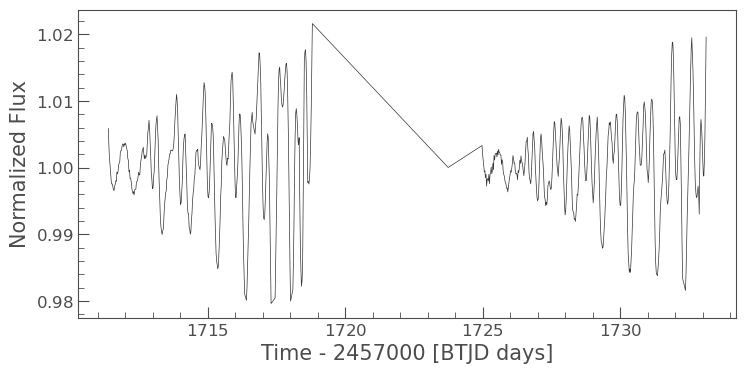

The best period is: 1.0030 d days


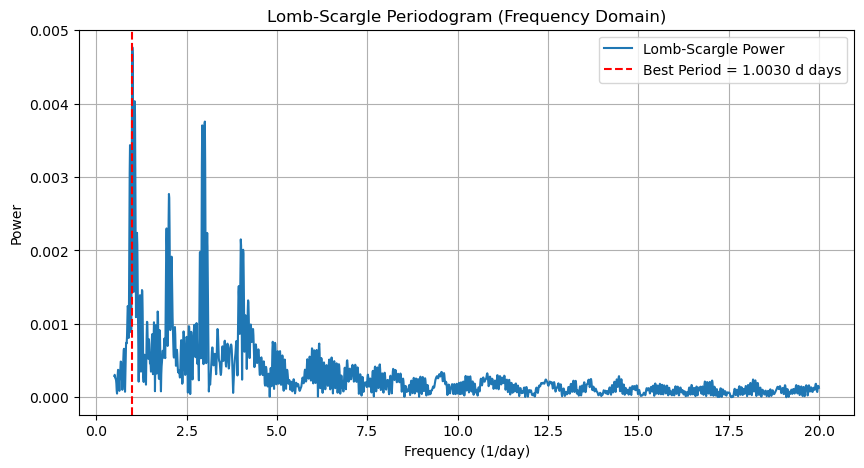

In [7]:
# Download and plot the TESS FFI cutout centered on the source
tpf_cutout = search_lc[1].download(cutout_size=12, quality_bitmask='hard')
tpf_cutout.plot();
# Add the TESS sector name as the title
plt.title(f"TESS Sector {tpf_cutout.sector}")

# Extract the lightcurves and make plots
extract_tess_lightcurve(tpf_cutout, target_source_name)

## Sector 55 - post-eruption 1

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


The simplified period analysis for the background-subtracted source lightcurve


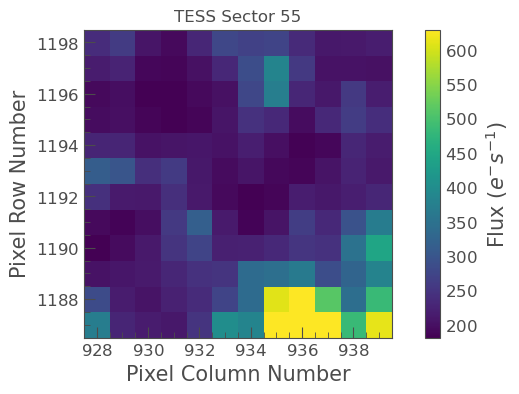

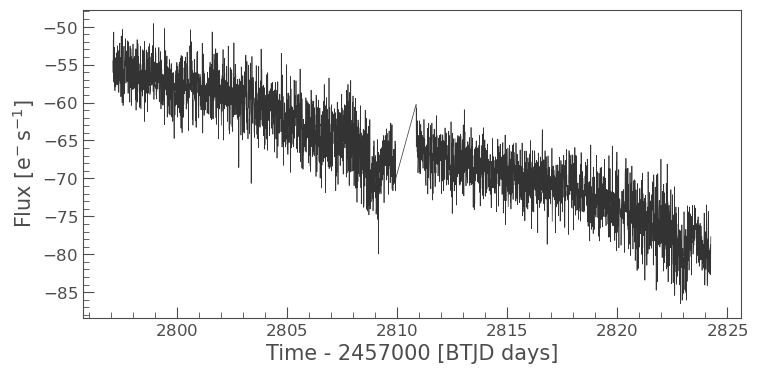

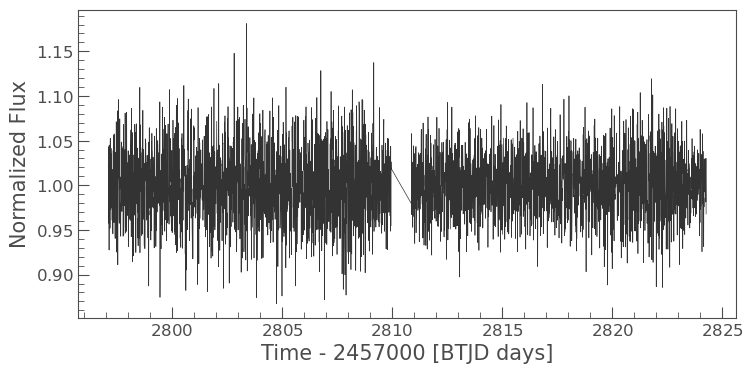

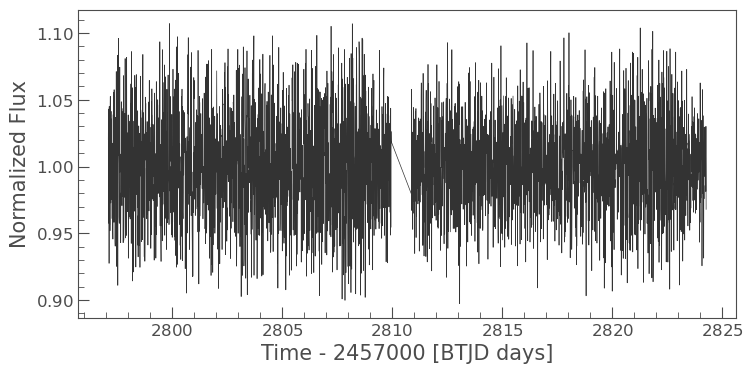

The best period is: 0.1343 d days


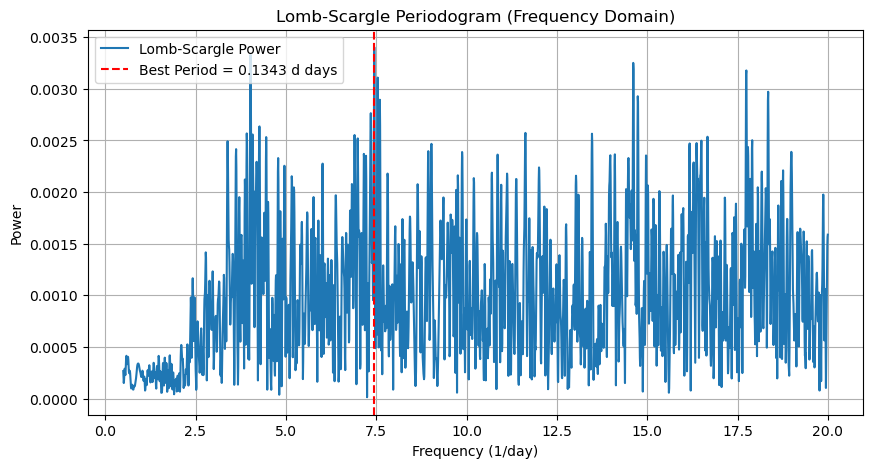

The simplified period analysis for the background lightcurve


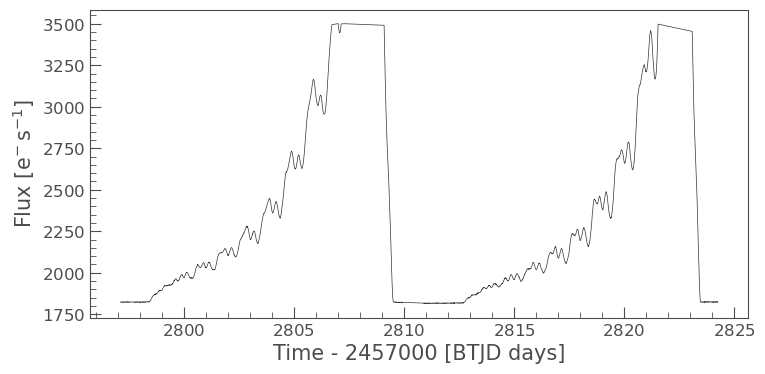

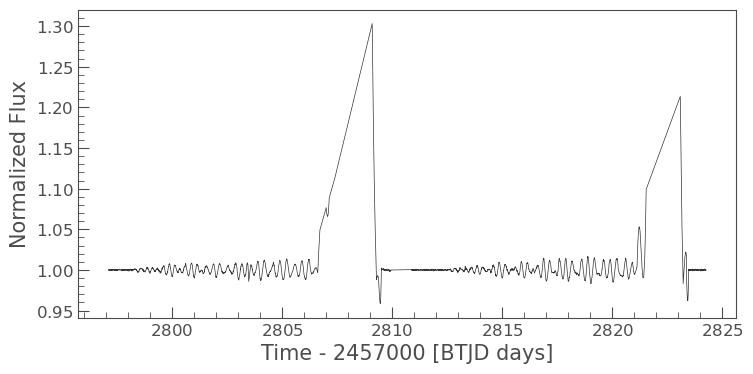

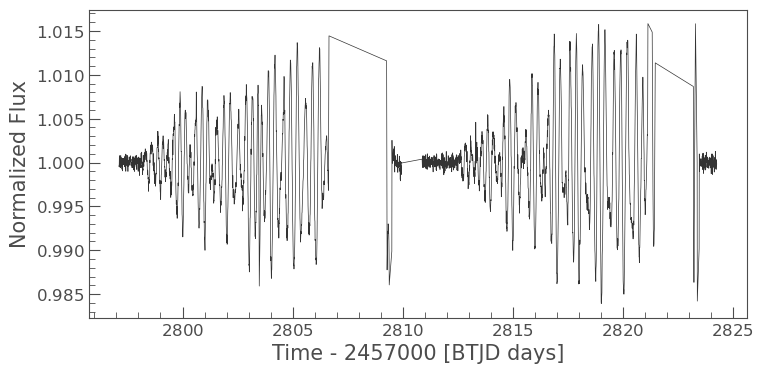

The best period is: 0.3337 d days


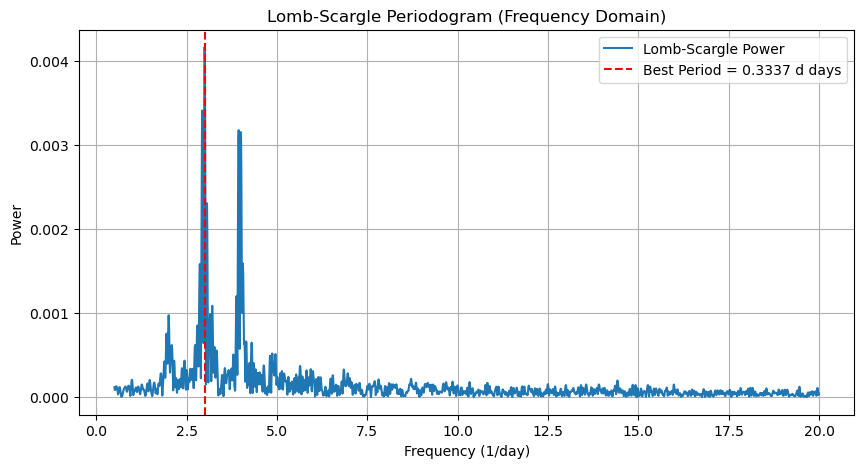

In [8]:
# Download and plot the TESS FFI cutout centered on the source
tpf_cutout = search_lc[3].download(cutout_size=12, quality_bitmask='hard')
tpf_cutout.plot();
# Add the TESS sector name as the title
plt.title(f"TESS Sector {tpf_cutout.sector}")

# Extract the lightcurves and make plots
extract_tess_lightcurve(tpf_cutout, target_source_name)

## Sector 81 - post-eruption 2

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


The simplified period analysis for the background-subtracted source lightcurve


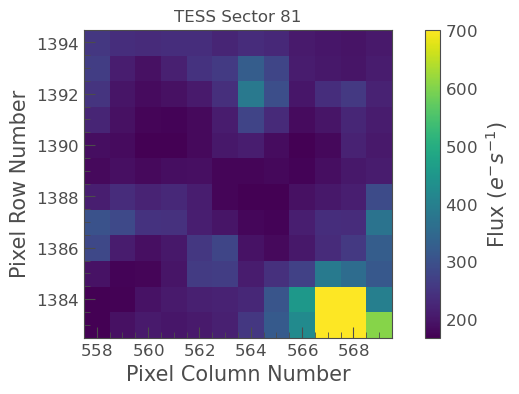

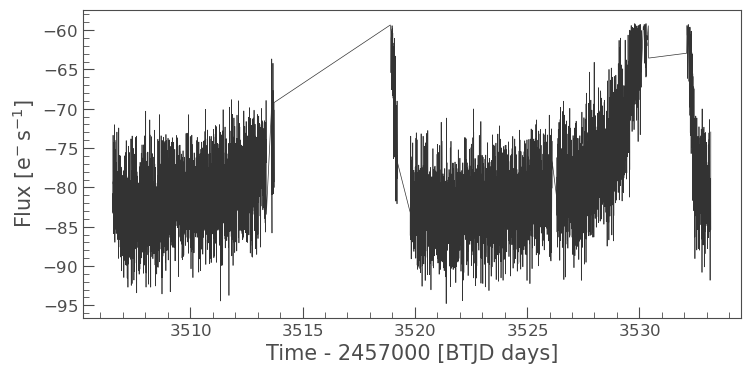

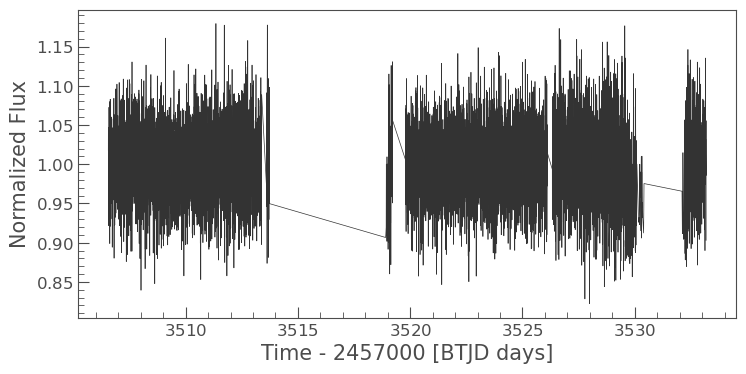

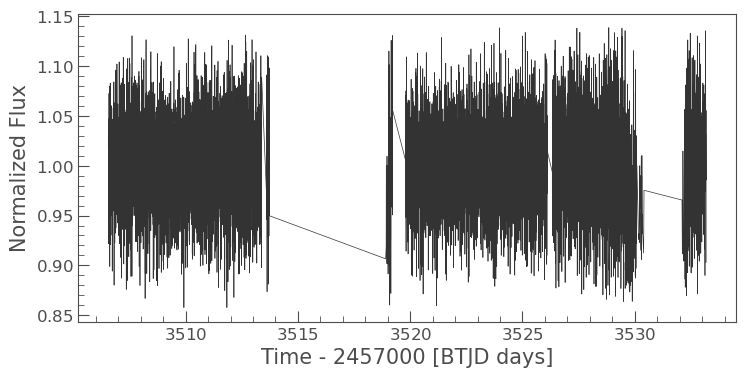

The best period is: 0.0759 d days


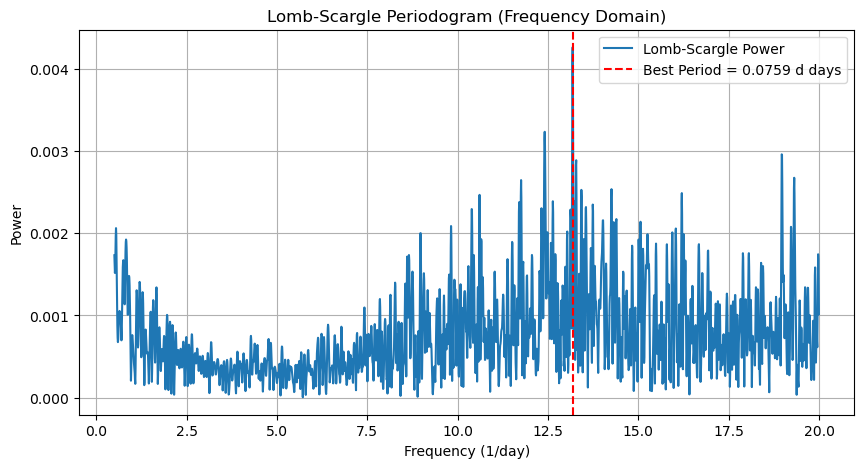

The simplified period analysis for the background lightcurve


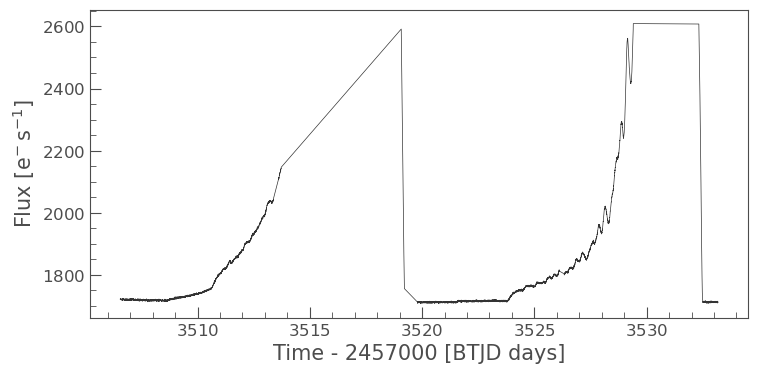

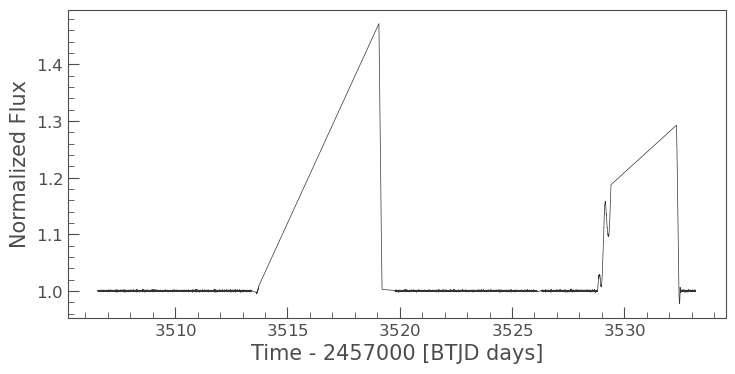

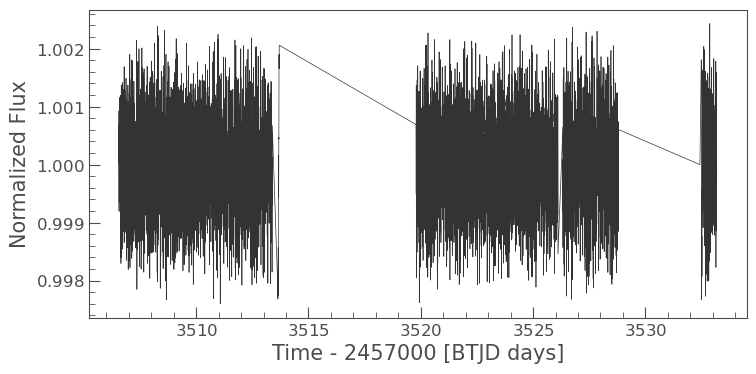

The best period is: 0.0863 d days


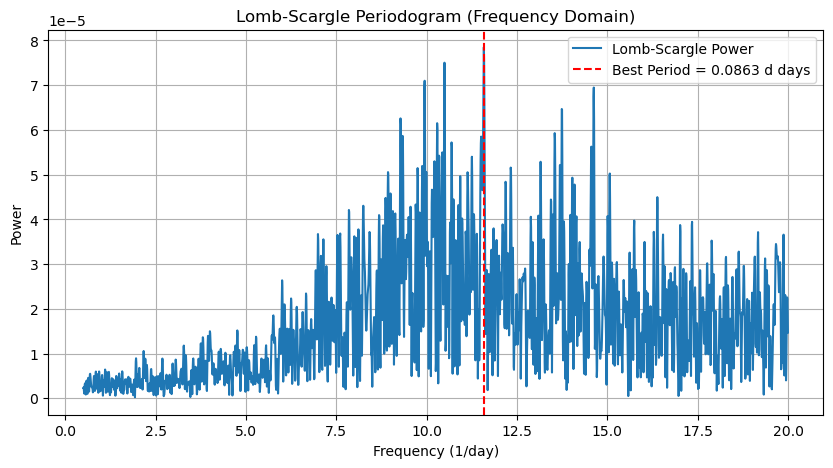

In [9]:
# Download and plot the TESS FFI cutout centered on the source
tpf_cutout = search_lc[4].download(cutout_size=12, quality_bitmask='hard')
tpf_cutout.plot();
# Add the TESS sector name as the title
plt.title(f"TESS Sector {tpf_cutout.sector}")

# Extract the lightcurves and make plots
extract_tess_lightcurve(tpf_cutout, target_source_name)

## Sector 82 - post-eruption 3

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


The simplified period analysis for the background-subtracted source lightcurve


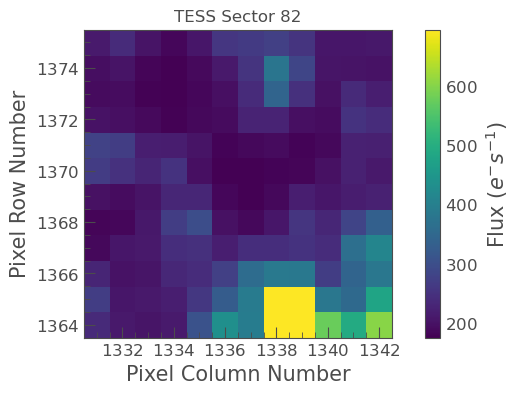

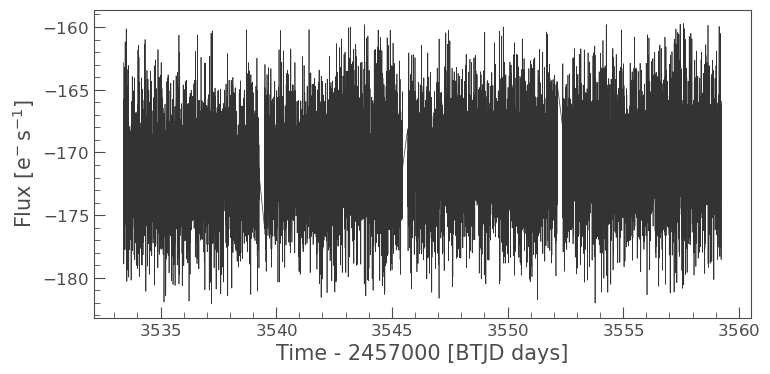

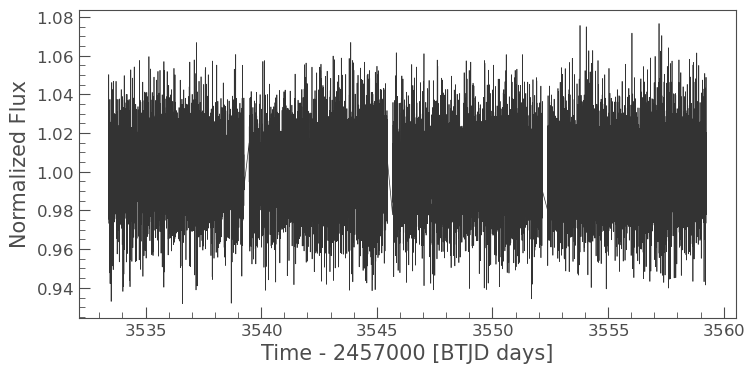

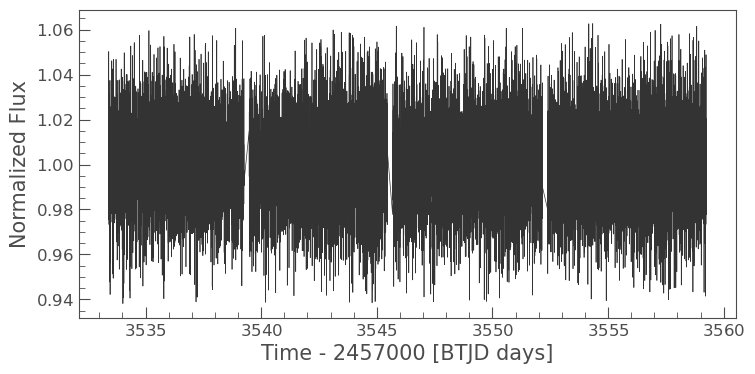

The best period is: 0.0745 d days


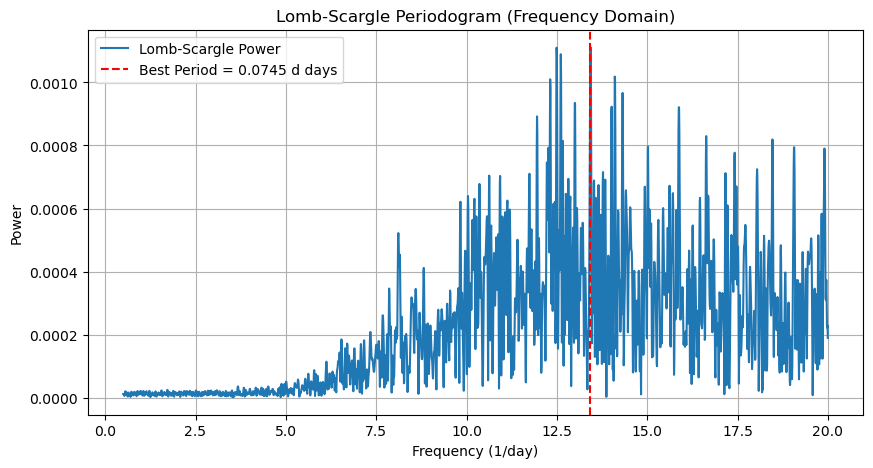

The simplified period analysis for the background lightcurve


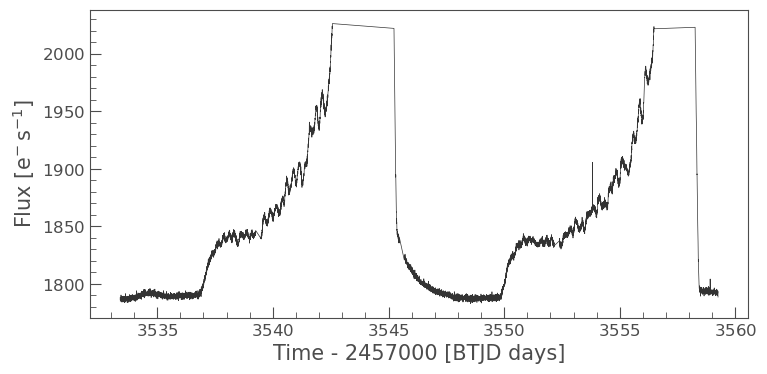

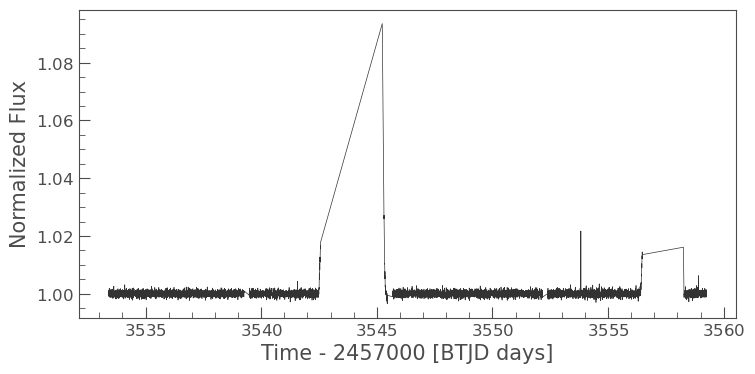

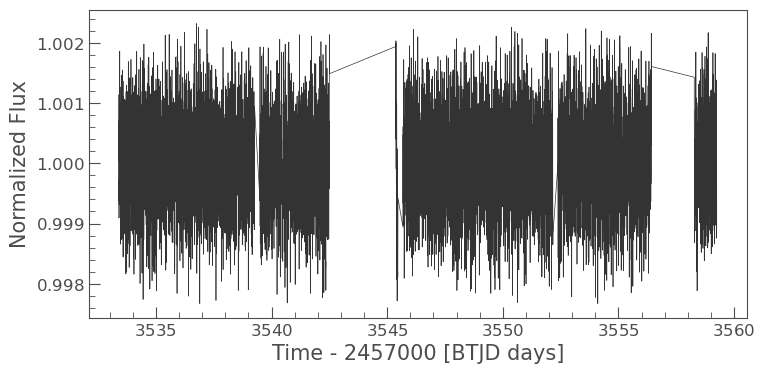

The best period is: 0.0773 d days


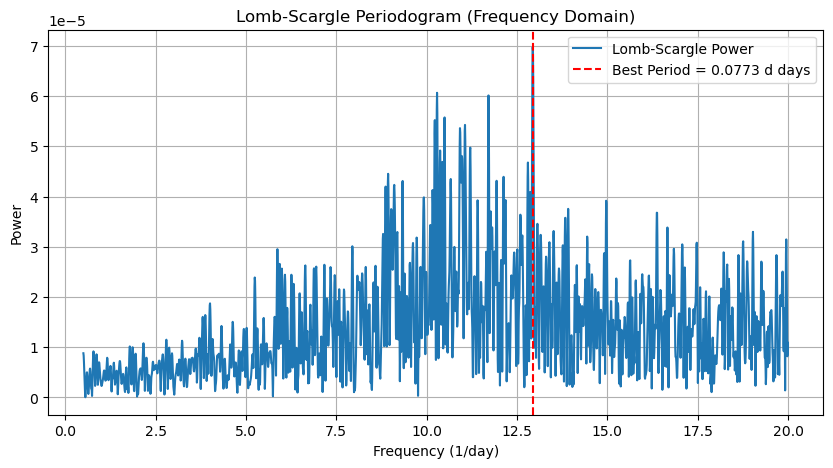

In [10]:
# Download and plot the TESS FFI cutout centered on the source
tpf_cutout = search_lc[5].download(cutout_size=12, quality_bitmask='hard')
tpf_cutout.plot();
# Add the TESS sector name as the title
plt.title(f"TESS Sector {tpf_cutout.sector}")

# Extract the lightcurves and make plots
extract_tess_lightcurve(tpf_cutout, target_source_name)

In [11]:
lk.show_citation_instructions()